# Homework 6

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.segmentation
from skimage import measure
from scipy import ndimage
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph

import warnings
warnings.filterwarnings('ignore')

# Задача №1 - Выделить береговую линию

Теперь приступим к задаче сегментации на картинках. Реализуйте программу, которая определить береговую линию, то есть разделит изображение на 2 класса: берег и вода. 

Примеры изображений:
<table><tr>
    <td> <img src="ships/0d5b831d8.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="ships/8bb60a003.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="ships/161dfbbdc.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [2]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(16, 16), constrained_layout=False)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.axis('off')
    plt.show()

In [3]:
def plot_images_grid(images):
    a = int(np.sqrt(len(images)))+1
    fig, axes = plt.subplots(len(images)//a+1, a, figsize=(16, 16))
    axes = axes.ravel()

    for i, im in enumerate(images):
        axes[i].imshow(im)
        axes[i].set_title(f'im {i}')

    for ax in axes:
        ax.axis('off')

In [4]:
def sea_cleaning(mask, hsv_im):
    hist = cv2.calcHist([hsv_im[:,:,0][mask]], [0], None, [180], [0, 180])
    sea_hist_max = np.argmax(hist)
    
    map_labels = measure.label(mask == 0)
    labels = np.unique(map_labels)
    labels = labels[1:]
    
    res_labels = []
    for l in labels:
        hist = cv2.calcHist([hsv_im[:,:,0][map_labels == l]], [0], None, [180], [0, 180])
    
        h_hist_max = np.argmax(hist)
        if (h_hist_max > 69 and h_hist_max < 150) or np.sum(hist) < hsv_im.shape[0]*hsv_im.shape[1]//400:
            res_labels.append(l)

    new_mask = mask.copy()
    for l in res_labels:
        new_mask |= map_labels == l
    return new_mask

In [30]:
def land_cleaning(mask, hsv_im):
    map_labels = measure.label(mask)
    labels = np.unique(map_labels)
    labels = labels[1:]
    l_hist_max = []
    for l in labels:
        hist = cv2.calcHist([hsv_im[:,:,0][map_labels == l]], [0], None, [180], [0, 180])
        l_hist_max.append(np.argmax(hist))
    
    if not l_hist_max:
      return mask.copy() 
    l_hist_max = np.array(l_hist_max)
    res_labels = labels[l_hist_max > l_hist_max.max()-20]
    new_mask = np.zeros_like(mask)
    for l in res_labels:
        new_mask |= map_labels == l
    return new_mask

In [31]:
def mask_land_cleaning(mask):
    new_mask = ndimage.binary_fill_holes(mask < 1)
    new_mask = new_mask == 0
    return new_mask

In [32]:
def draw_contours(see_mask, image):
    plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
    plt.imshow(image, cmap=plt.cm.gray)
    cmap = plt.cm.get_cmap('Spectral', 3)

    plt.contour(see_mask, contours=1,
                       colors=[cmap(1)])
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [33]:
def draw_im(image):
    plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [34]:
def get_map_label(image, n_clusters):
    connectivity = grid_to_graph(*image.shape)
    X = np.reshape(image, (-1, 1))
    ward = AgglomerativeClustering(n_clusters=n_clusters,
                                       linkage='ward', connectivity=connectivity, distance_threshold=None).fit(X)
    return np.reshape(ward.labels_, image.shape)[:,:,0]

In [35]:
def clusters(images, n_clusters=10, k_resize=2):
    if type(images) != list:
        ims = [images.copy()]
    else:
        ims = [im.copy() for im in images]
    
    for i_im, im in enumerate(ims):
        print('___________________________')
        print('image:', i_im)

        hsv_im = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
        im = skimage.transform.resize(im, tuple(map(int, np.array(im.shape[:2])/k_resize)))
        hsv_im = cv2.resize(hsv_im.copy(), tuple(map(int, np.array(hsv_im.shape[:2])/k_resize)))

        label = get_map_label(im, n_clusters)
        
        res_labels = []
        for l in range(np.unique(label).size):
            hist = cv2.calcHist([hsv_im[:,:,0][label == l]], [0], None, [180], [0, 180])
            h_hist_max = np.argmax(hist)
            if h_hist_max > 34 and h_hist_max < 150:
                res_labels.append(l)
        
        if not res_labels:
            draw_im(im)
            continue
        
        see_label = np.zeros(label.shape, dtype = bool)
        for l in res_labels:
            see_label |= label == l
        
        see_label = mask_land_cleaning(see_label)
        see_label = sea_cleaning(see_label, hsv_im)
        see_label = land_cleaning(see_label, hsv_im)         
        
        draw_contours(see_label, im)

In [36]:
def get_images(path='./ships'):
    images = []
    for path_im in os.listdir(path):
        images.append(cv2.imread(path+'/'+path_im))
        images[-1] = cv2.cvtColor(images[-1], cv2.COLOR_BGR2RGB)
    return images

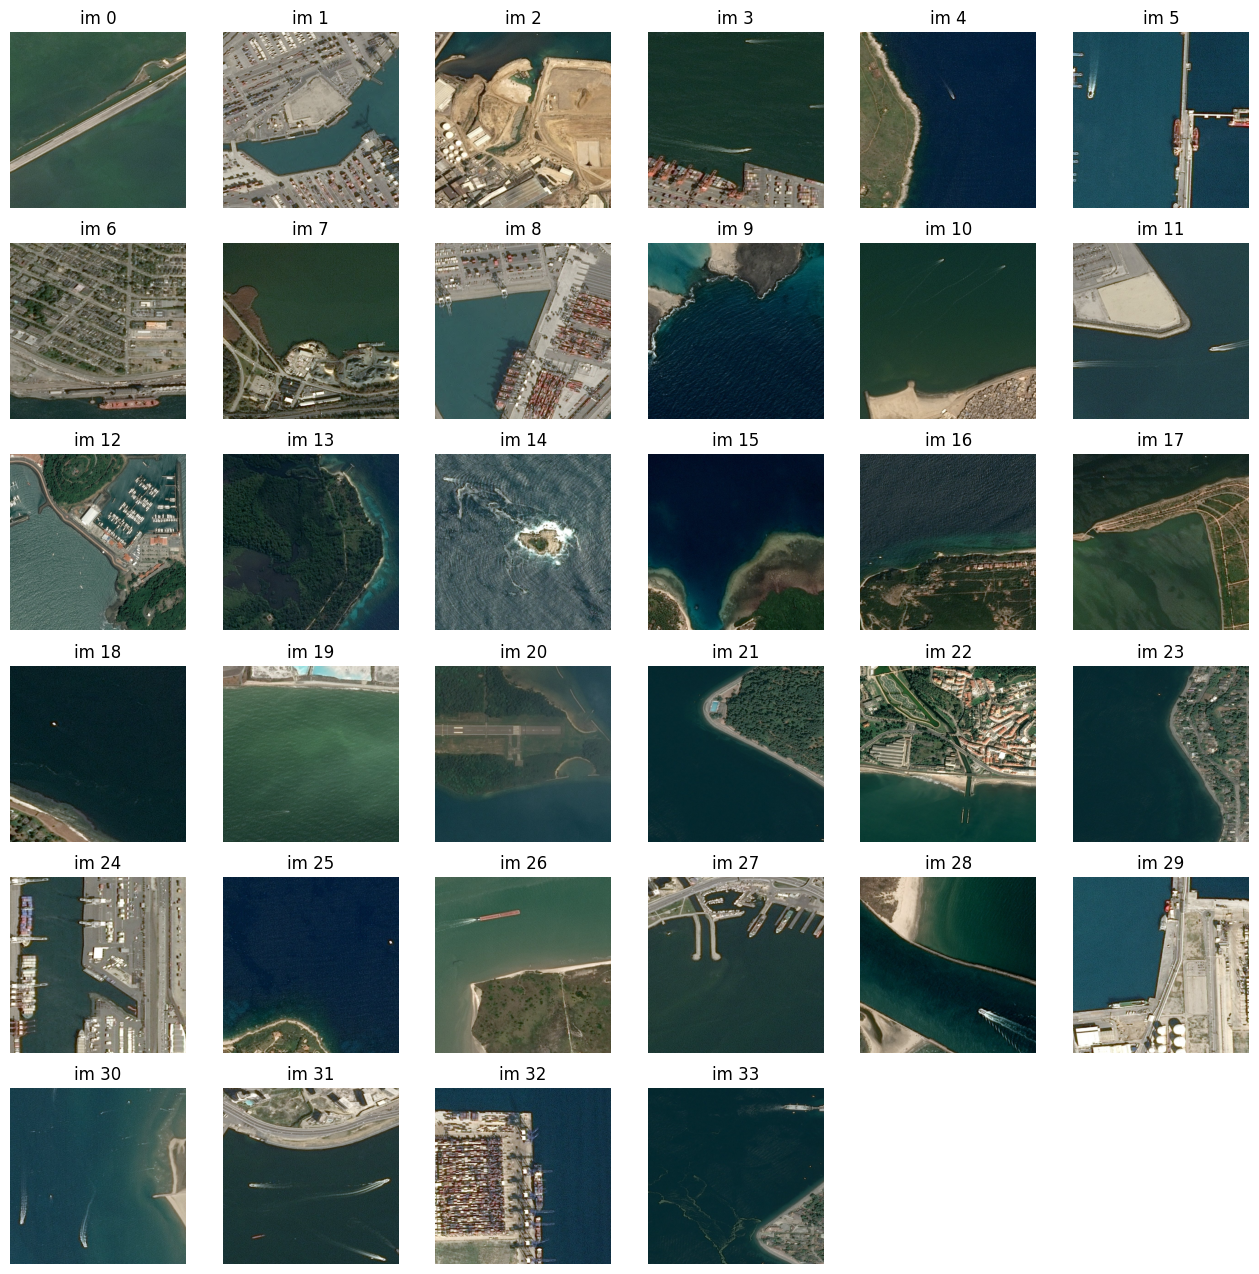

In [37]:
images = get_images()
plot_images_grid(images)

___________________________
image: 0


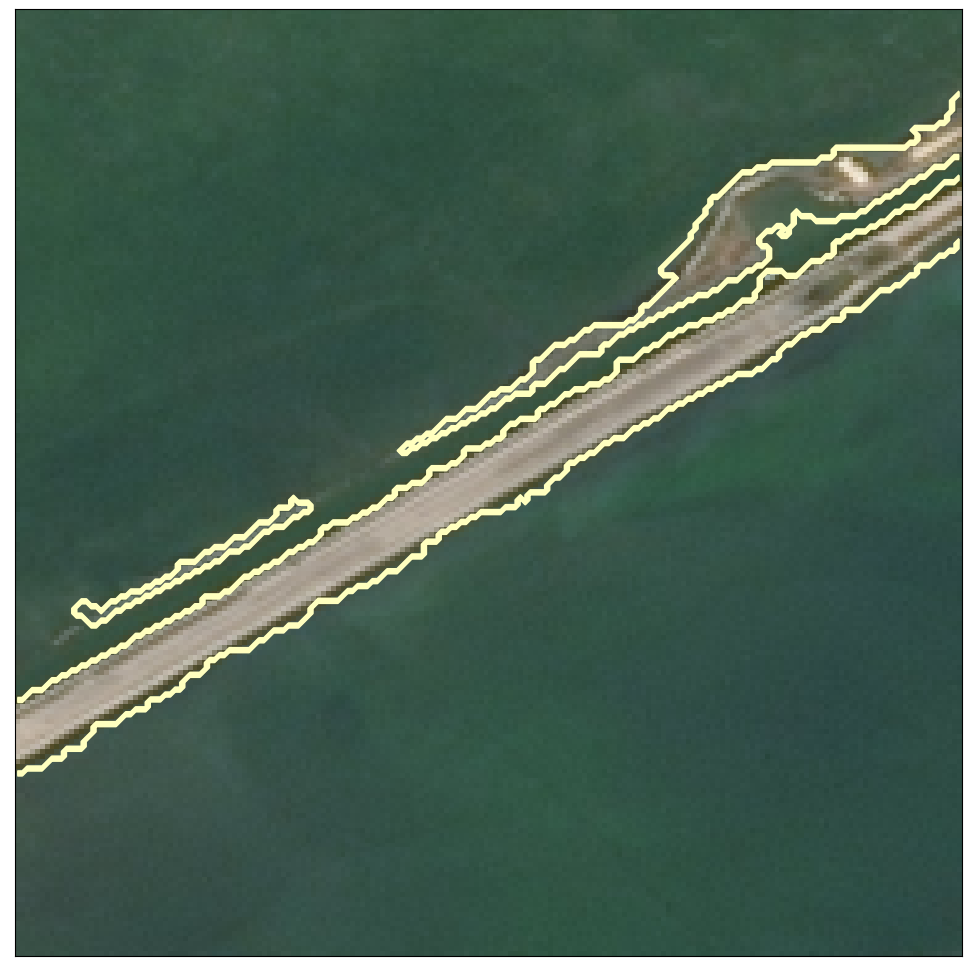

___________________________
image: 1


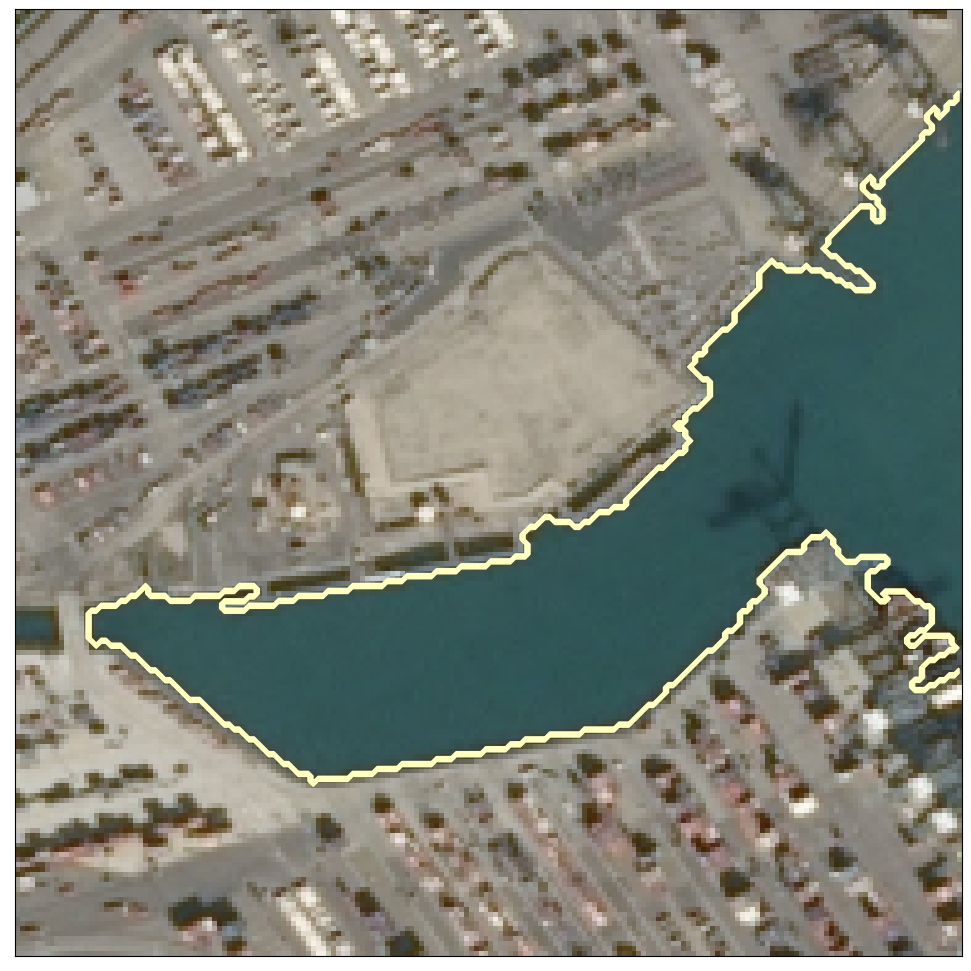

___________________________
image: 2


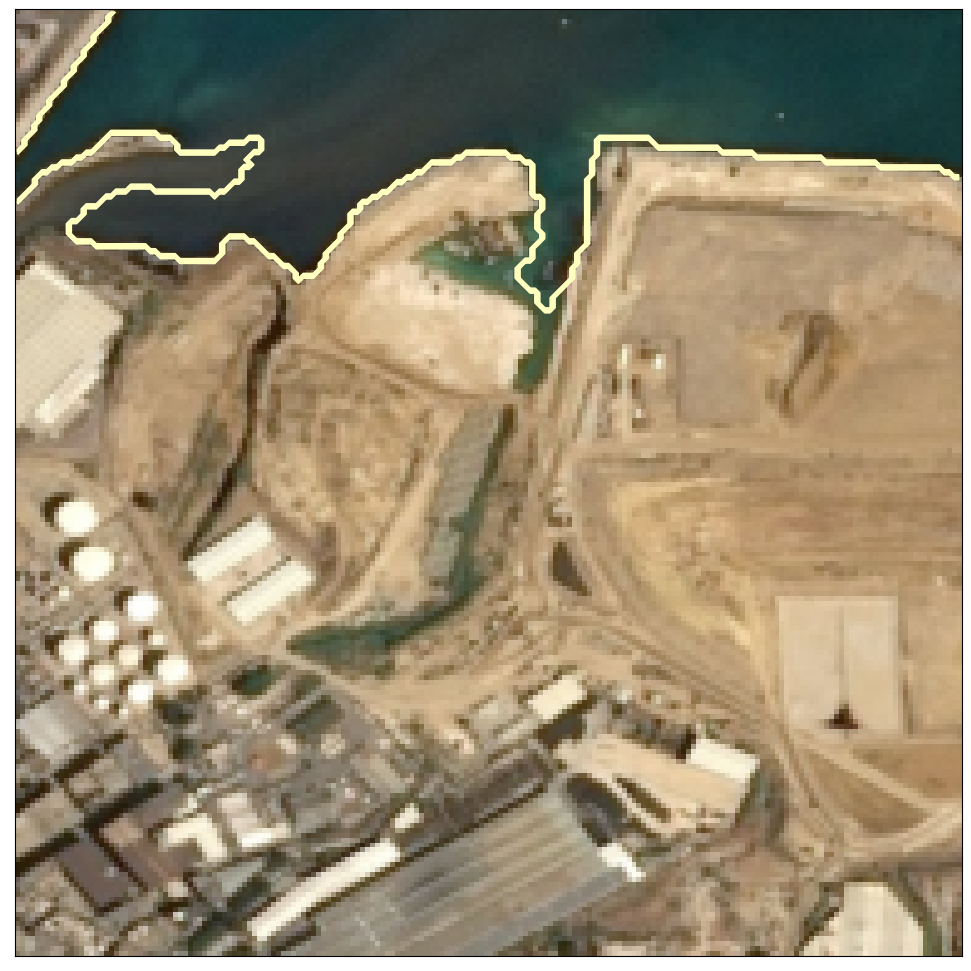

___________________________
image: 3


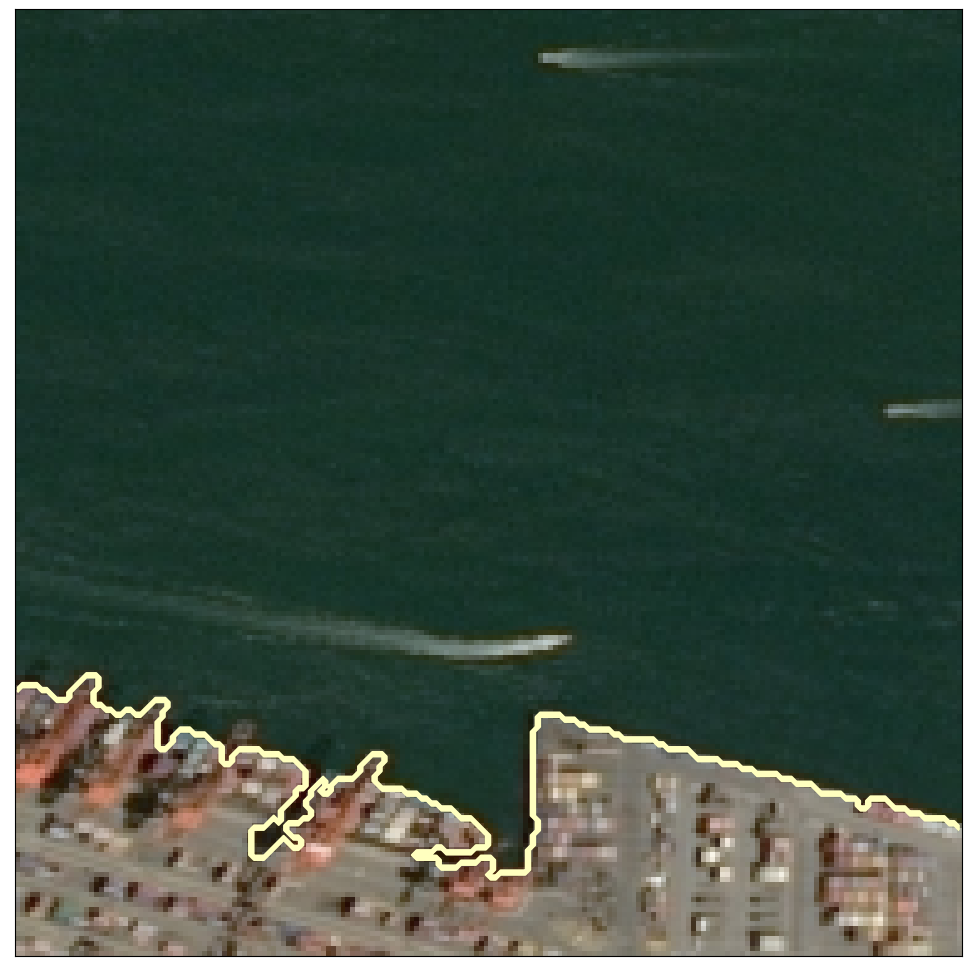

___________________________
image: 4


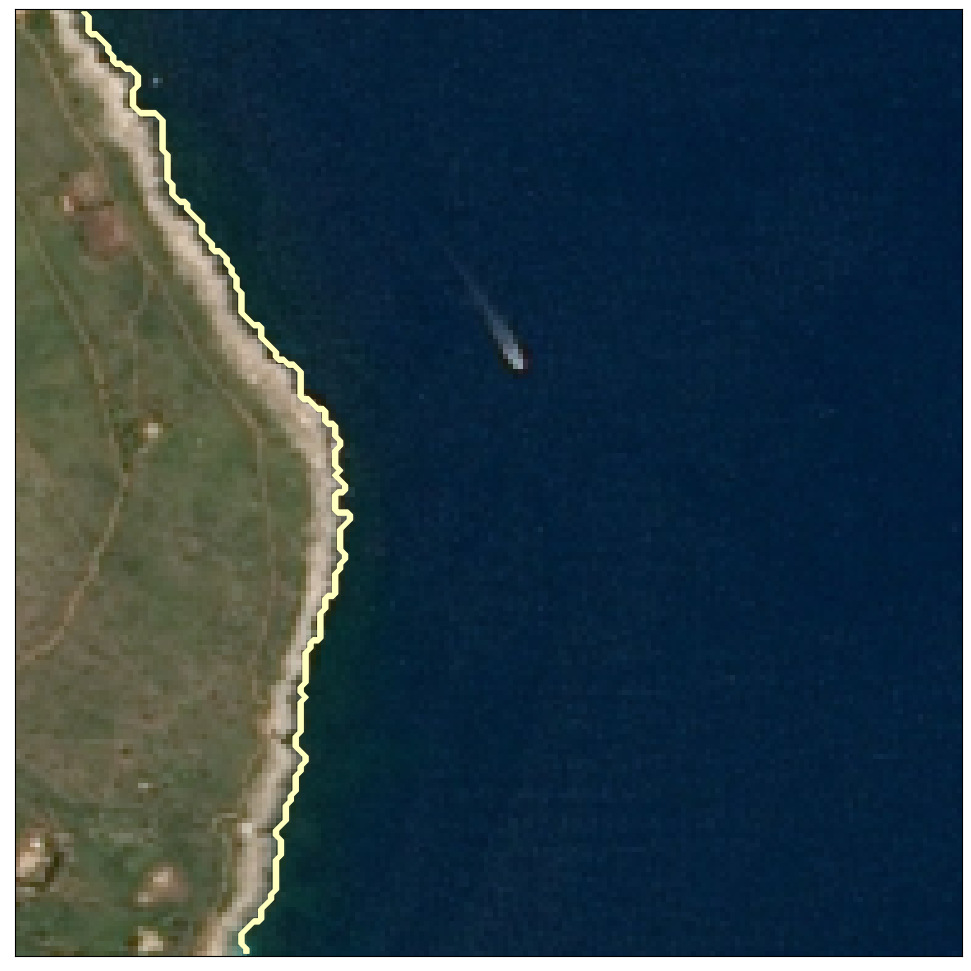

___________________________
image: 5


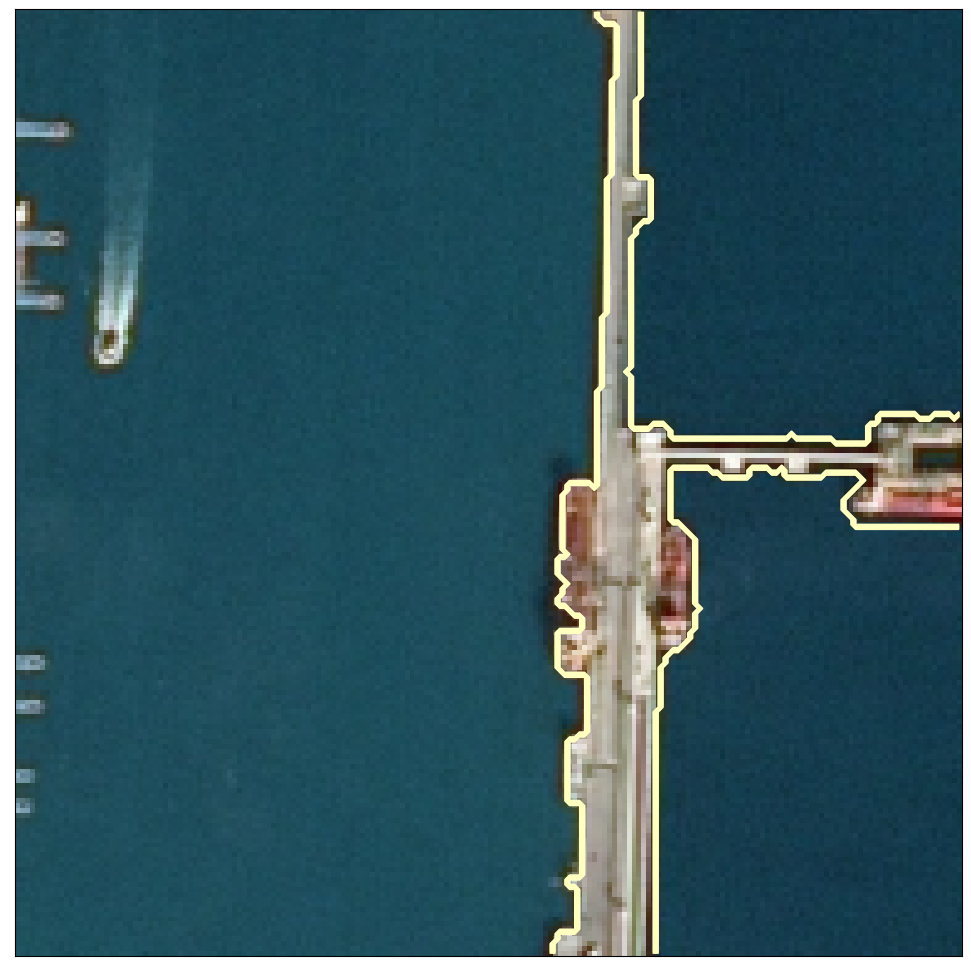

___________________________
image: 6


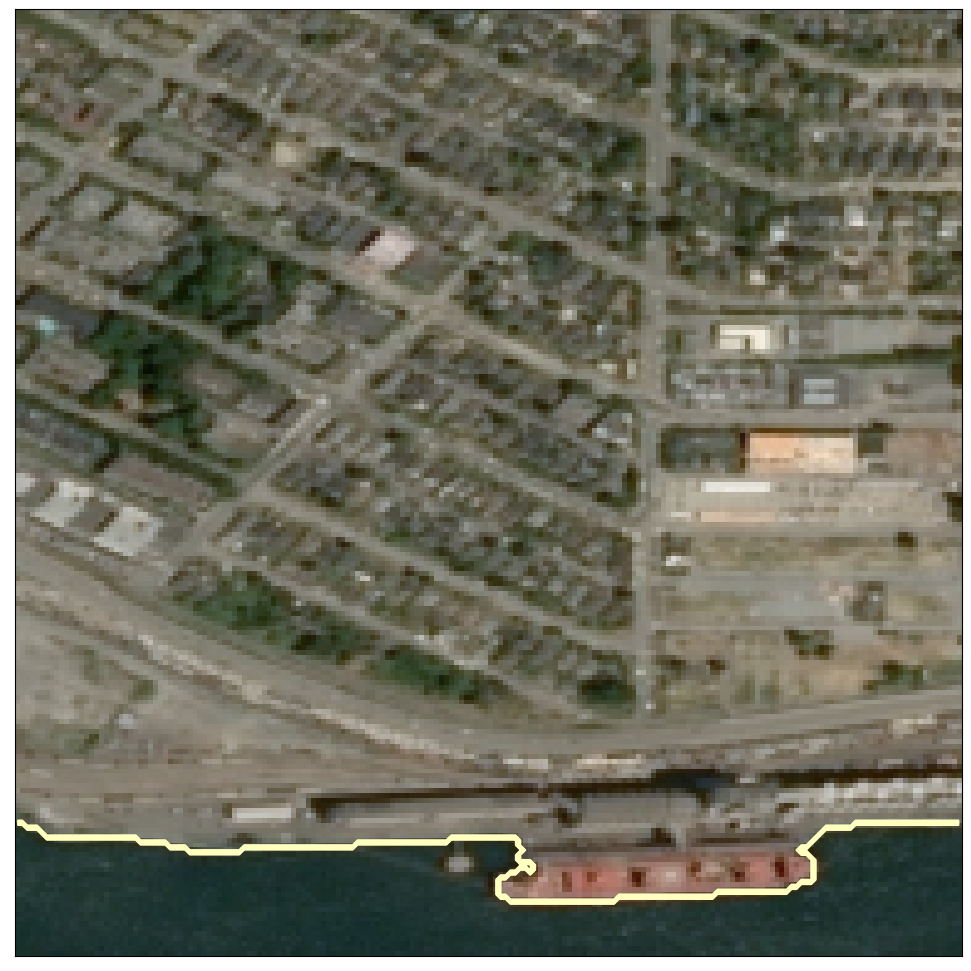

___________________________
image: 7


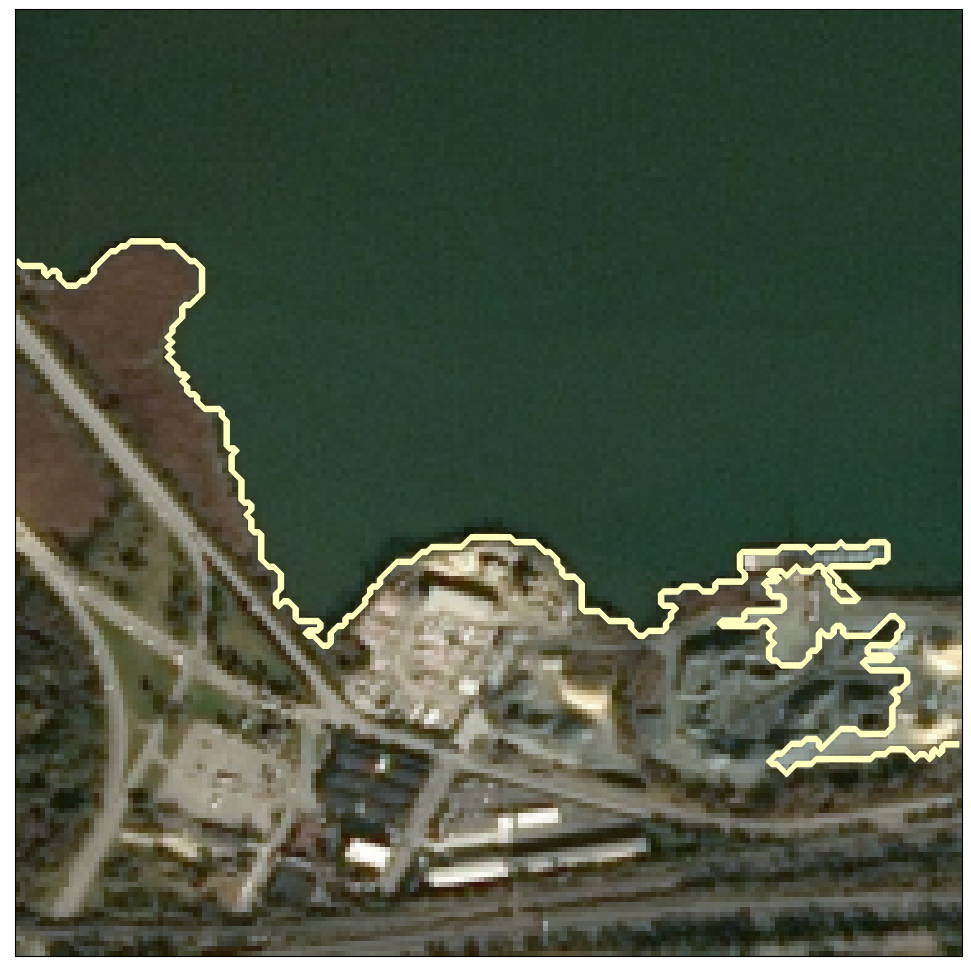

___________________________
image: 8


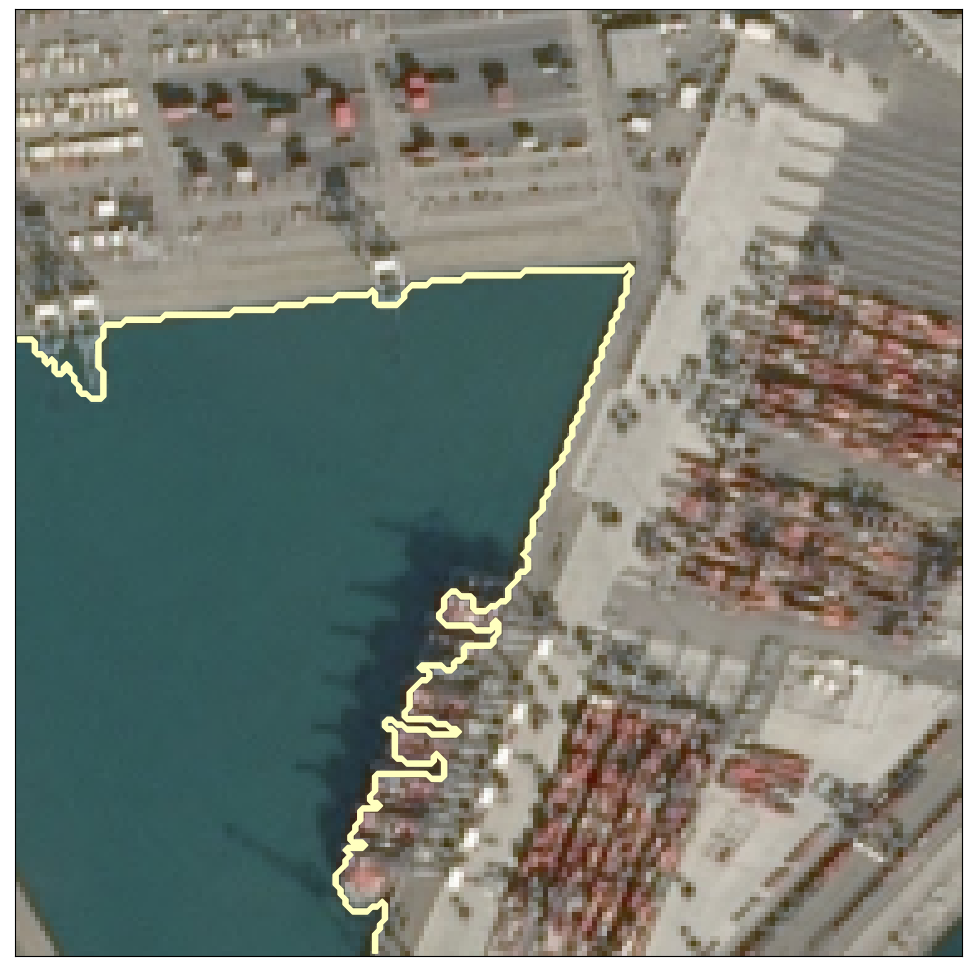

___________________________
image: 9


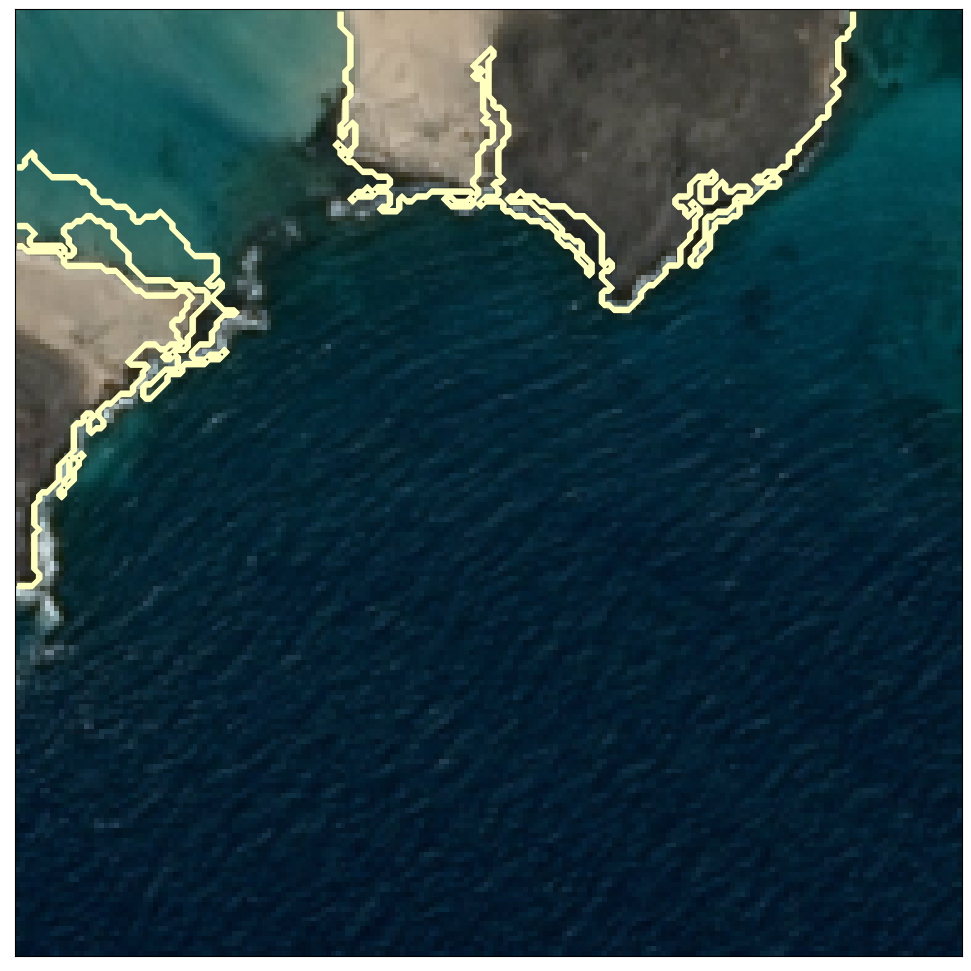

___________________________
image: 10


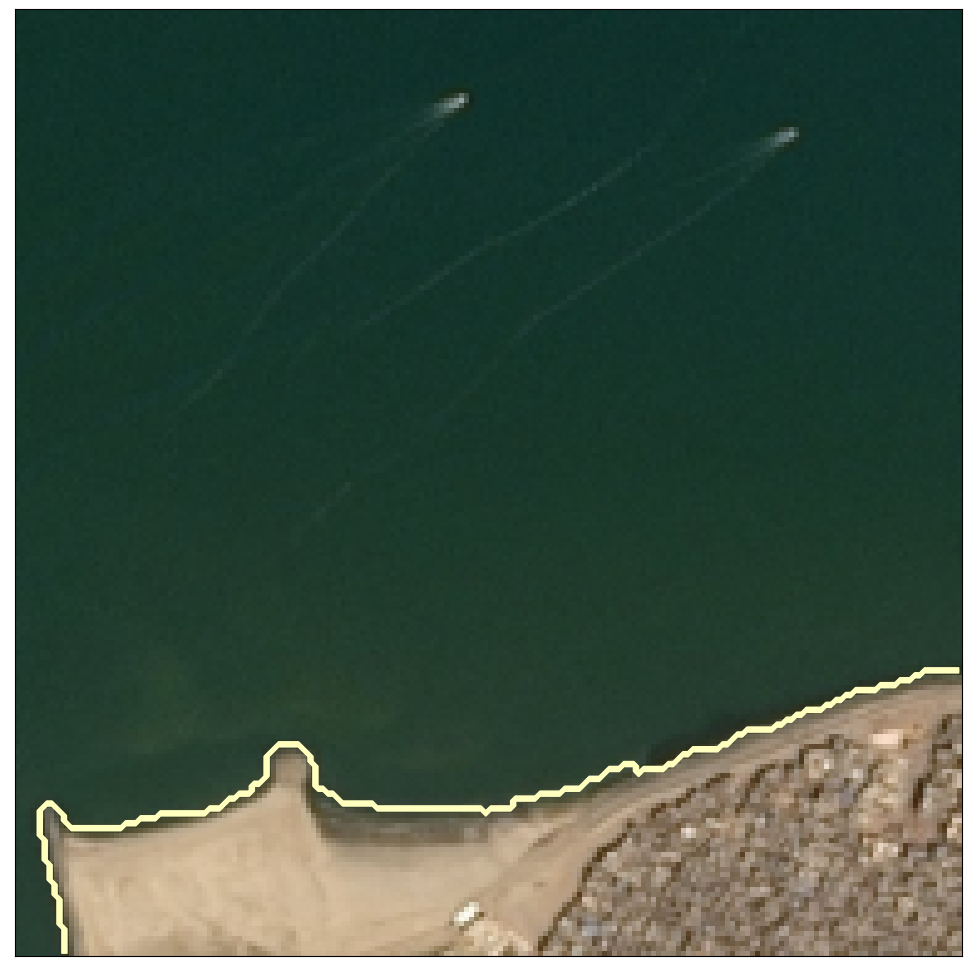

___________________________
image: 11


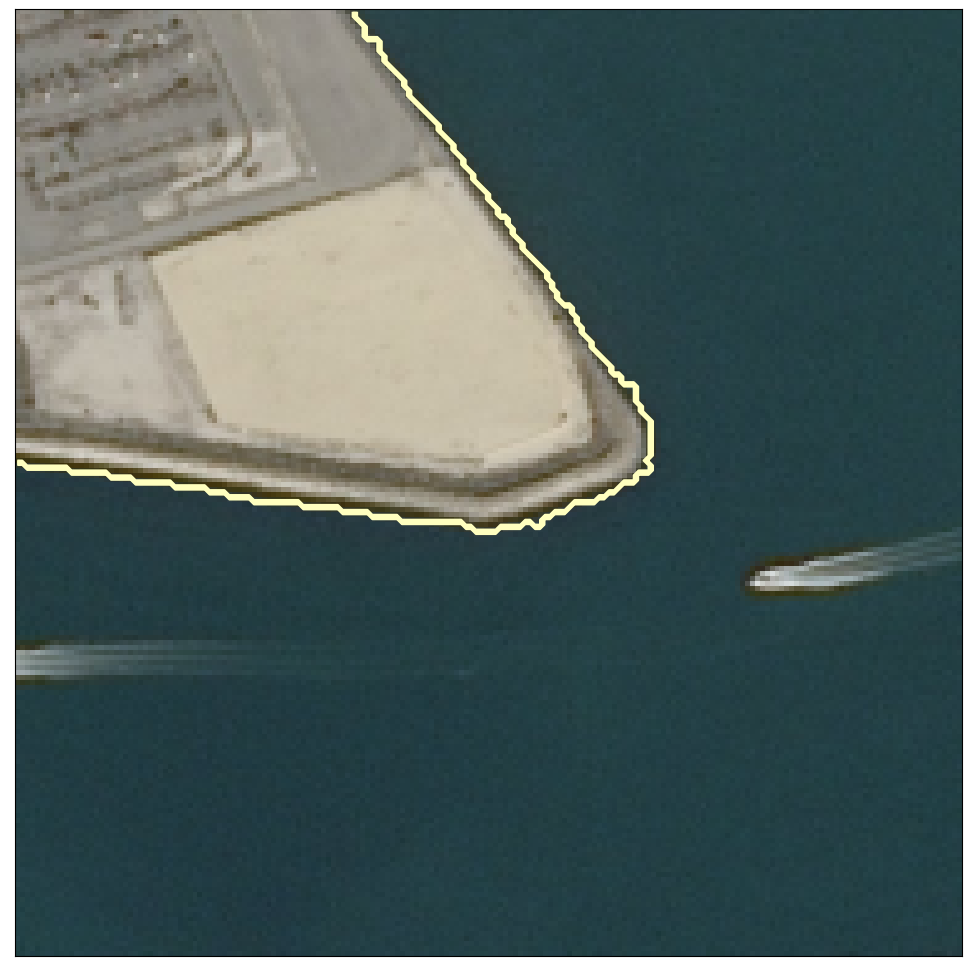

___________________________
image: 12


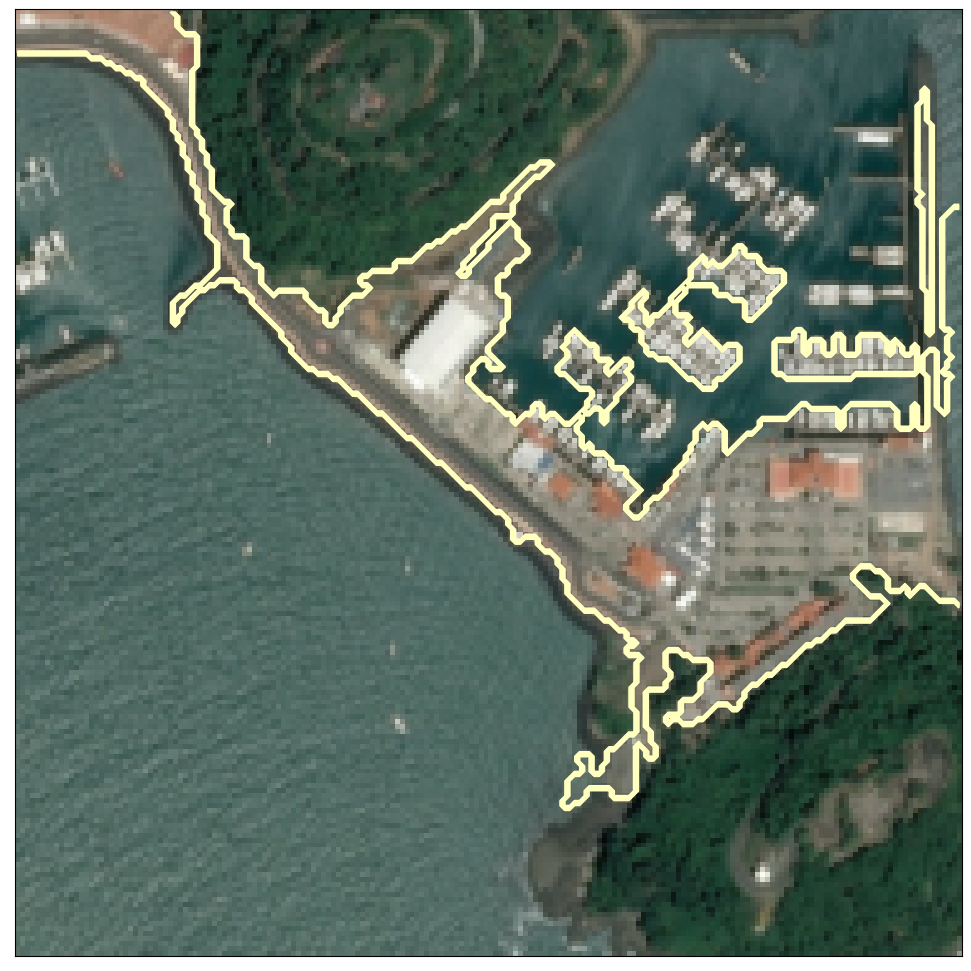

___________________________
image: 13


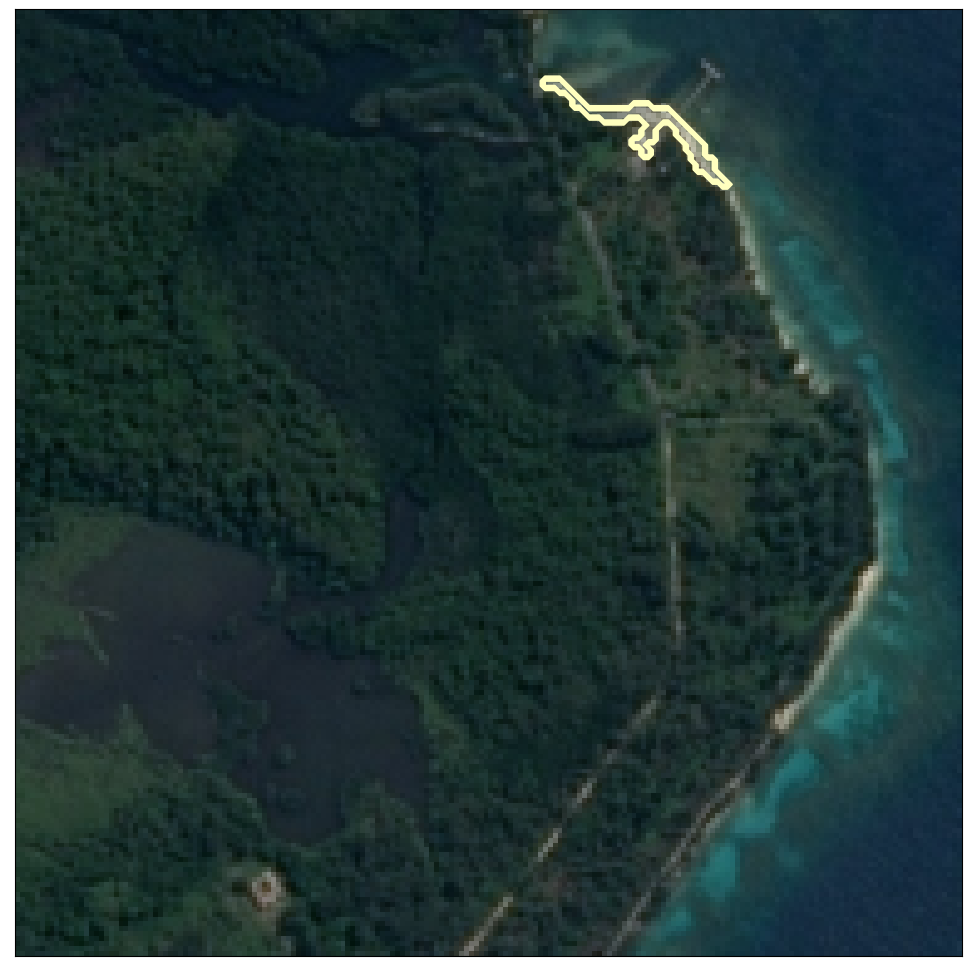

___________________________
image: 14


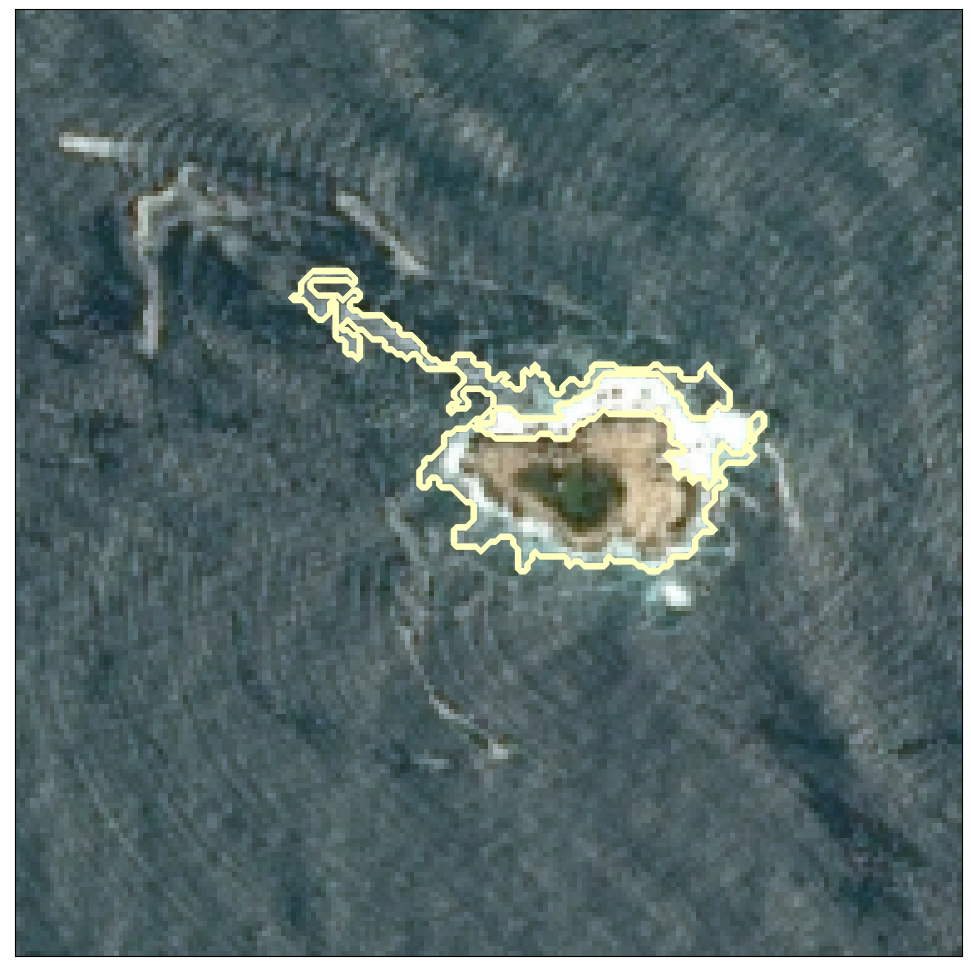

___________________________
image: 15


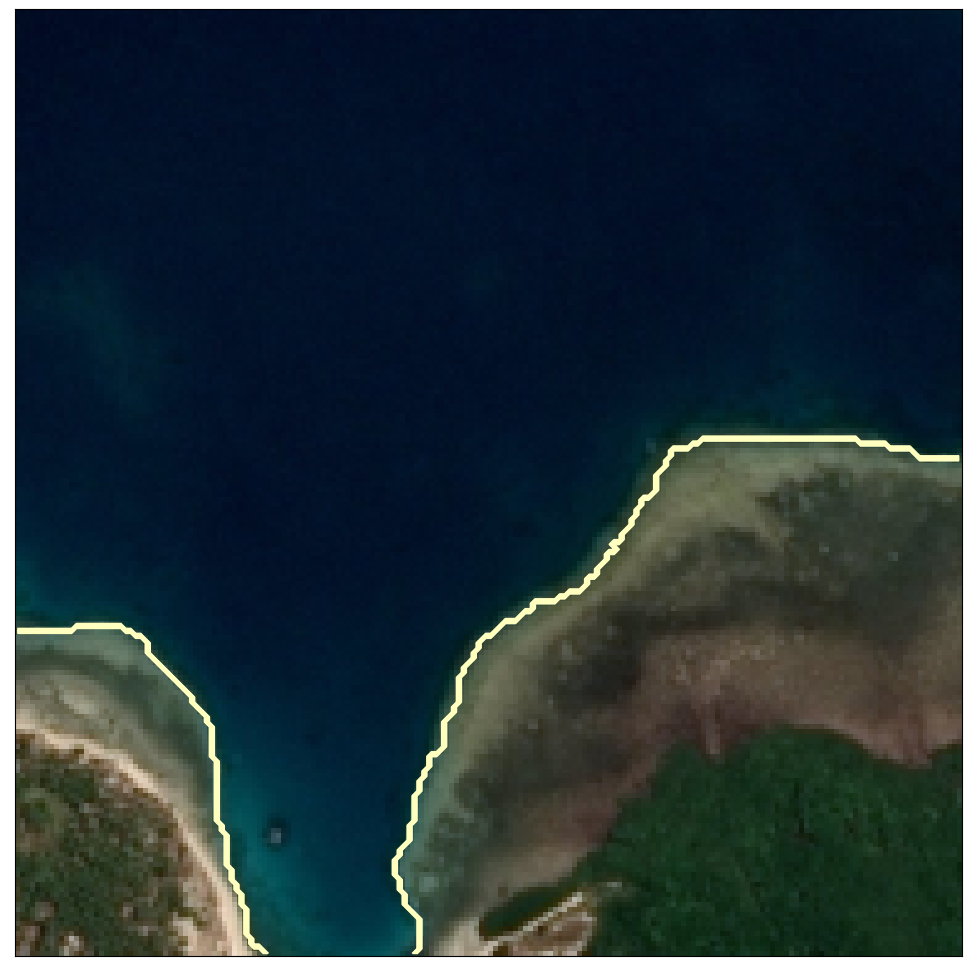

___________________________
image: 16


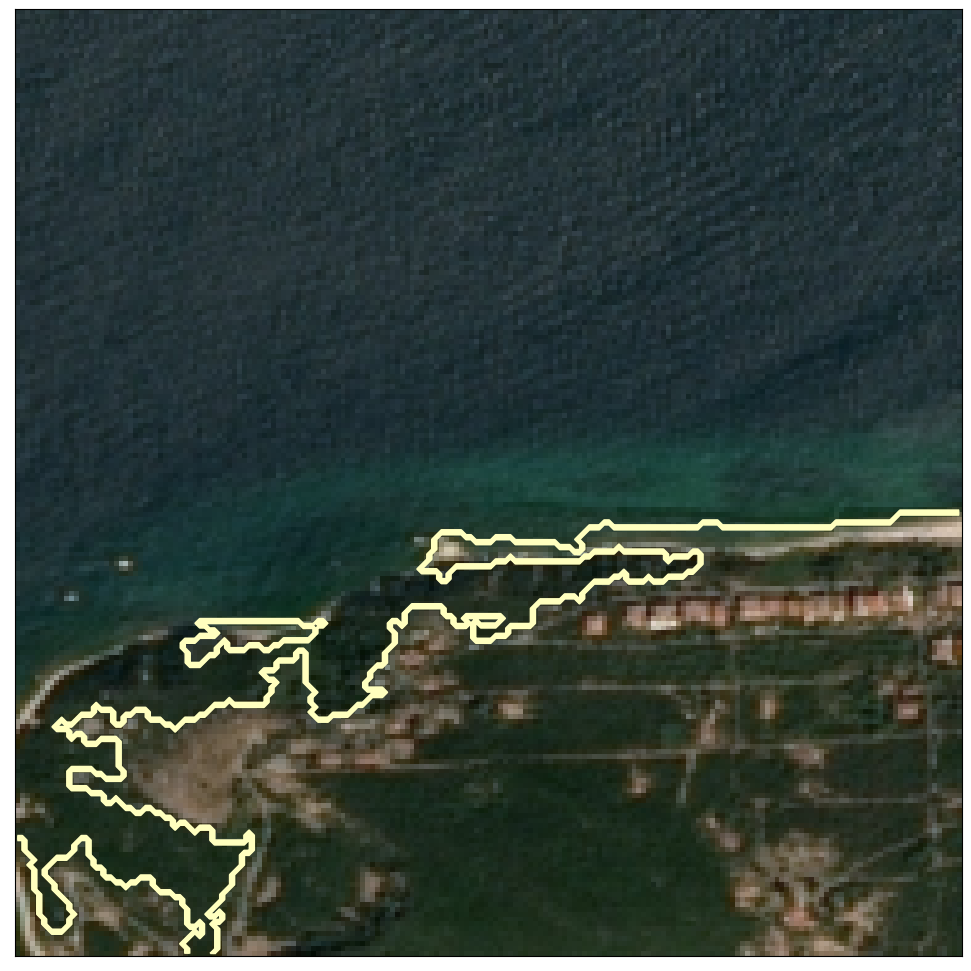

___________________________
image: 17


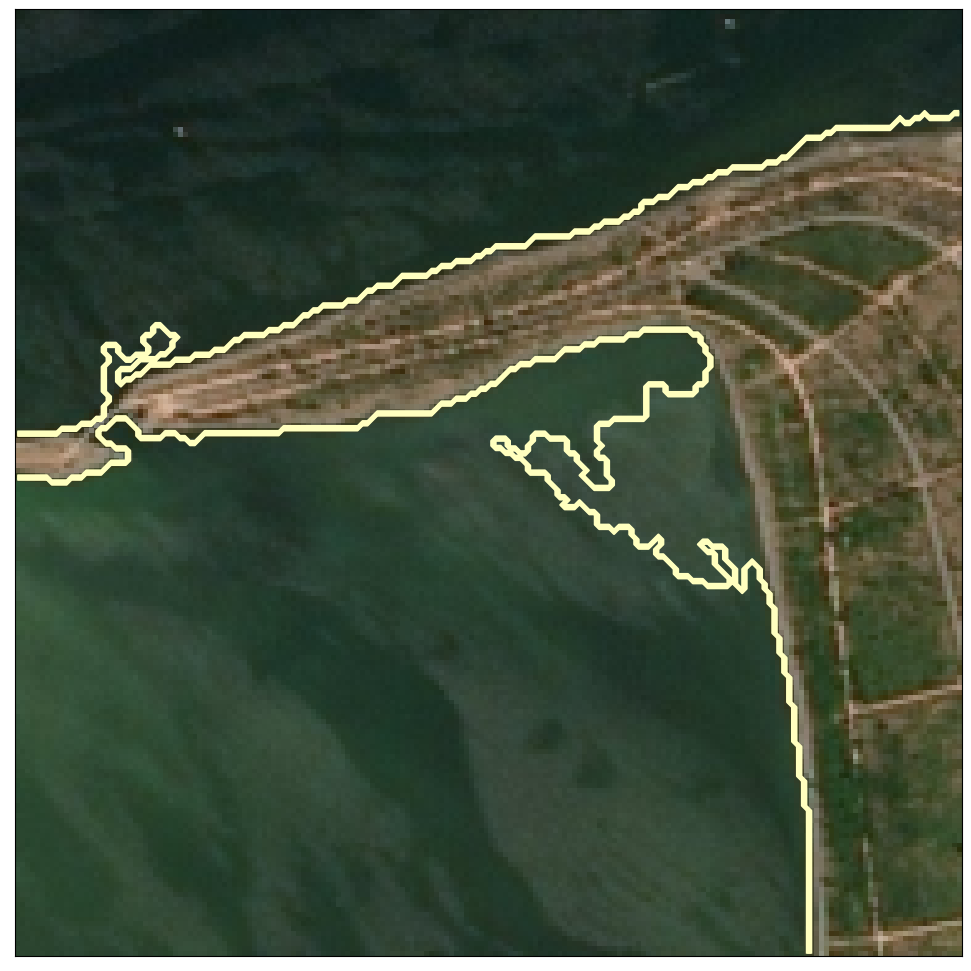

___________________________
image: 18


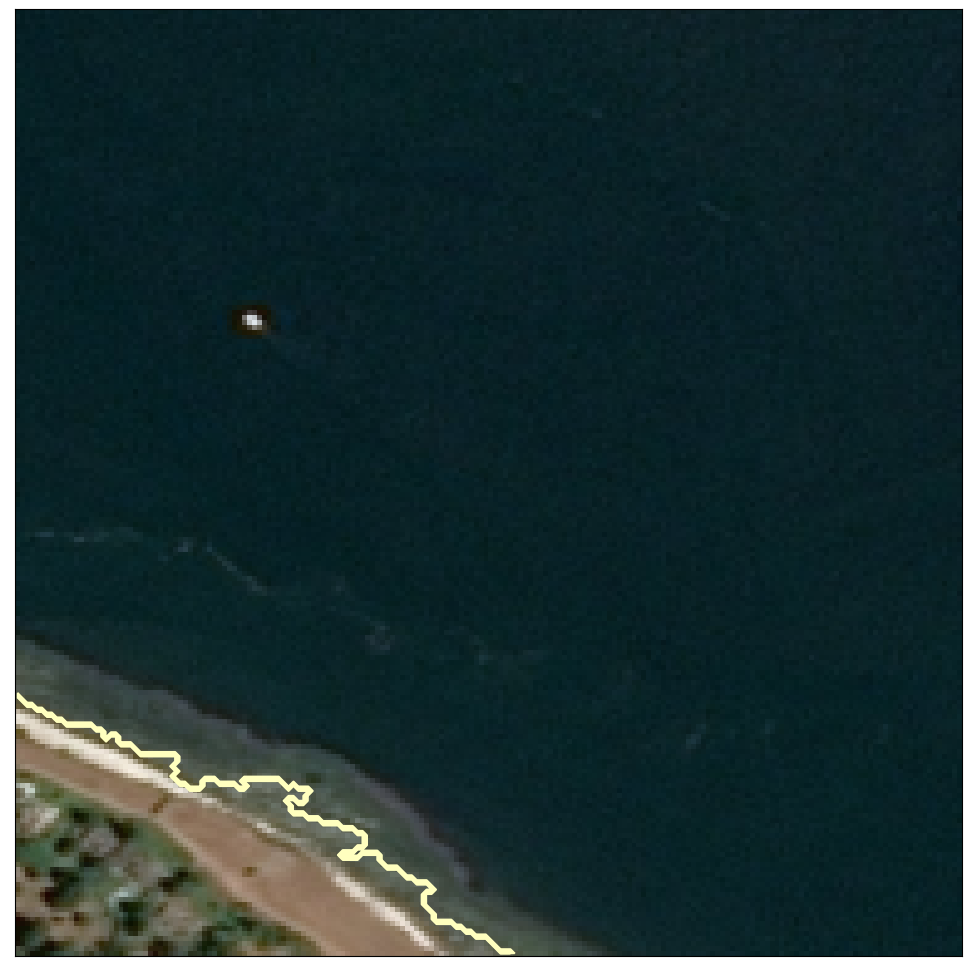

___________________________
image: 19


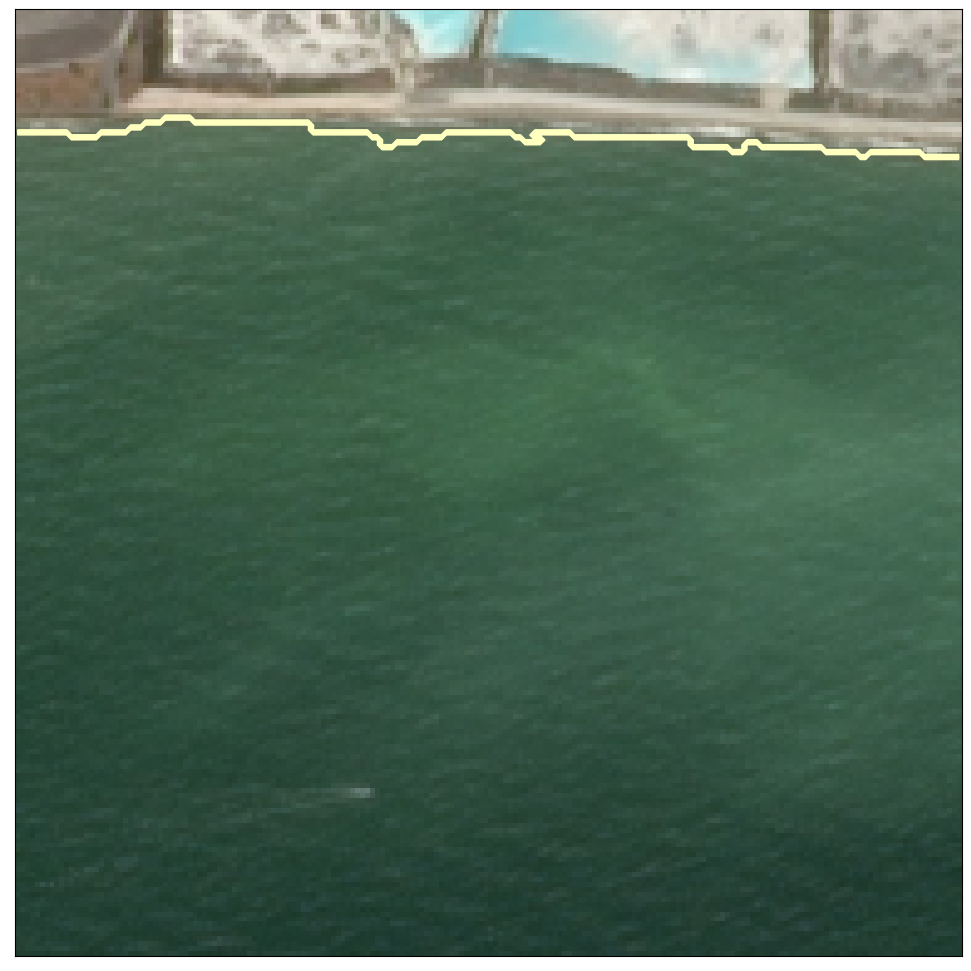

___________________________
image: 20


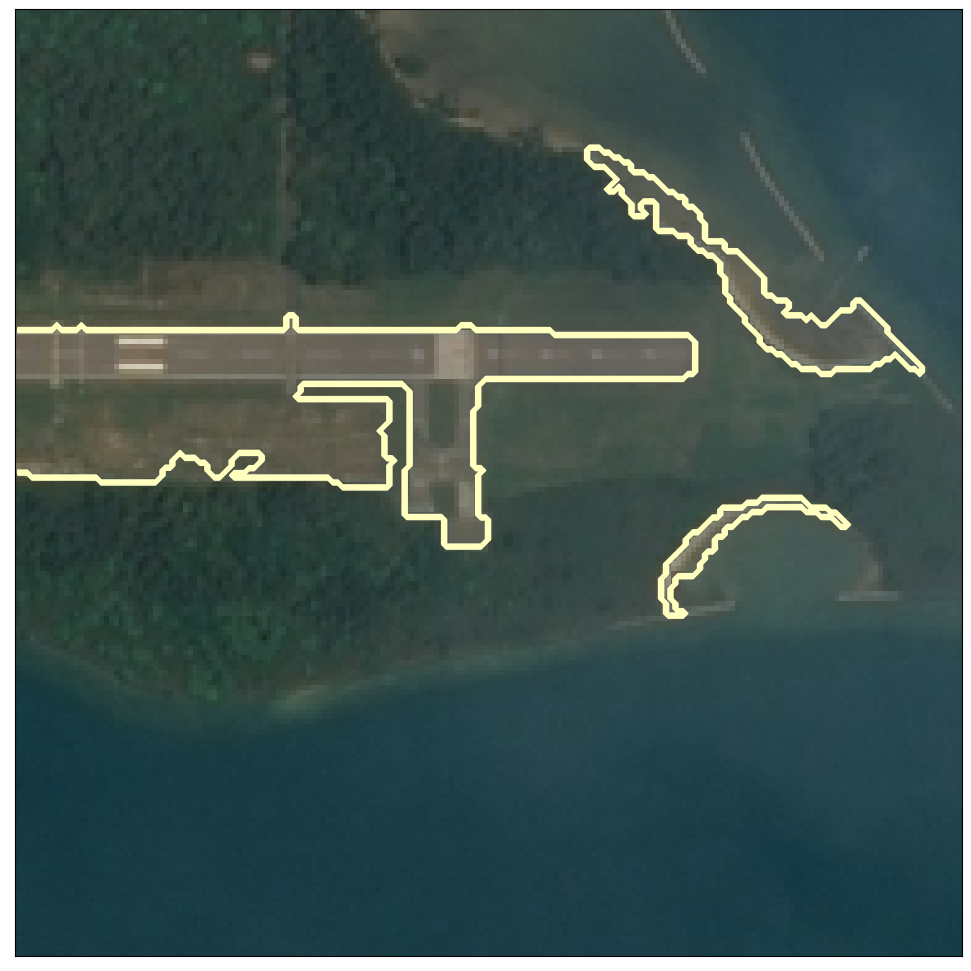

___________________________
image: 21


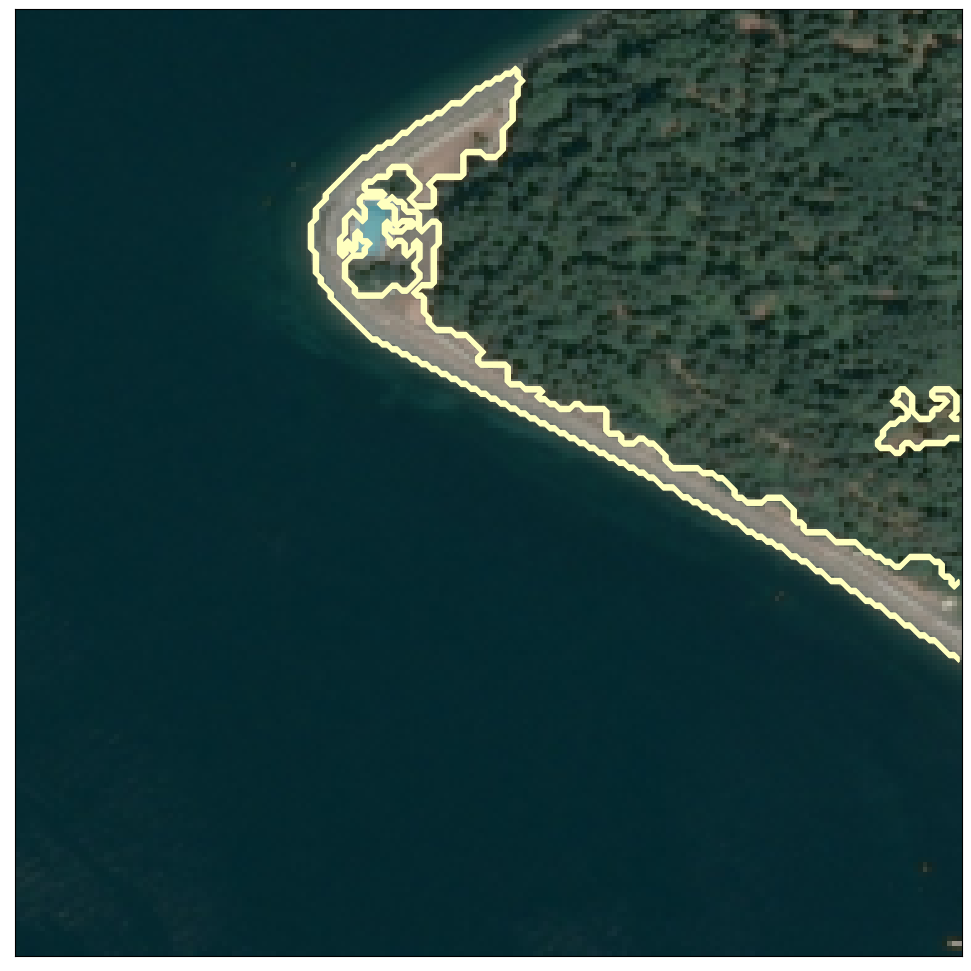

___________________________
image: 22


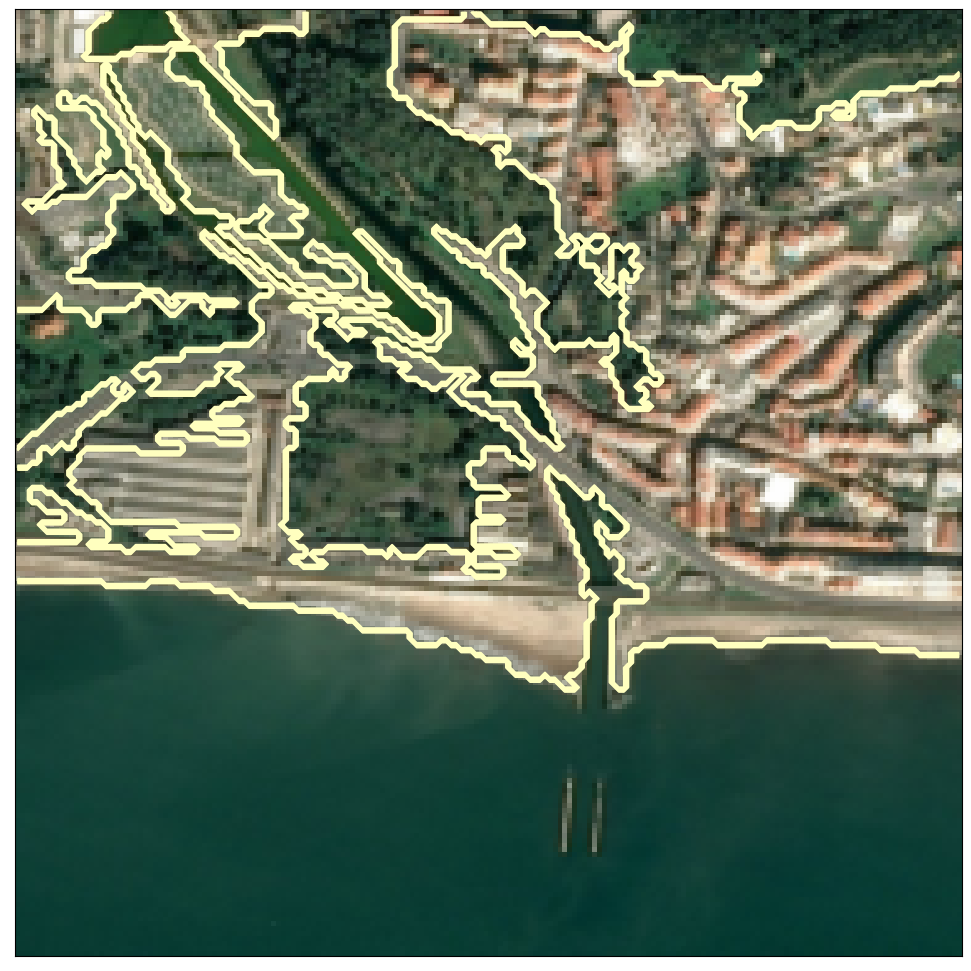

___________________________
image: 23


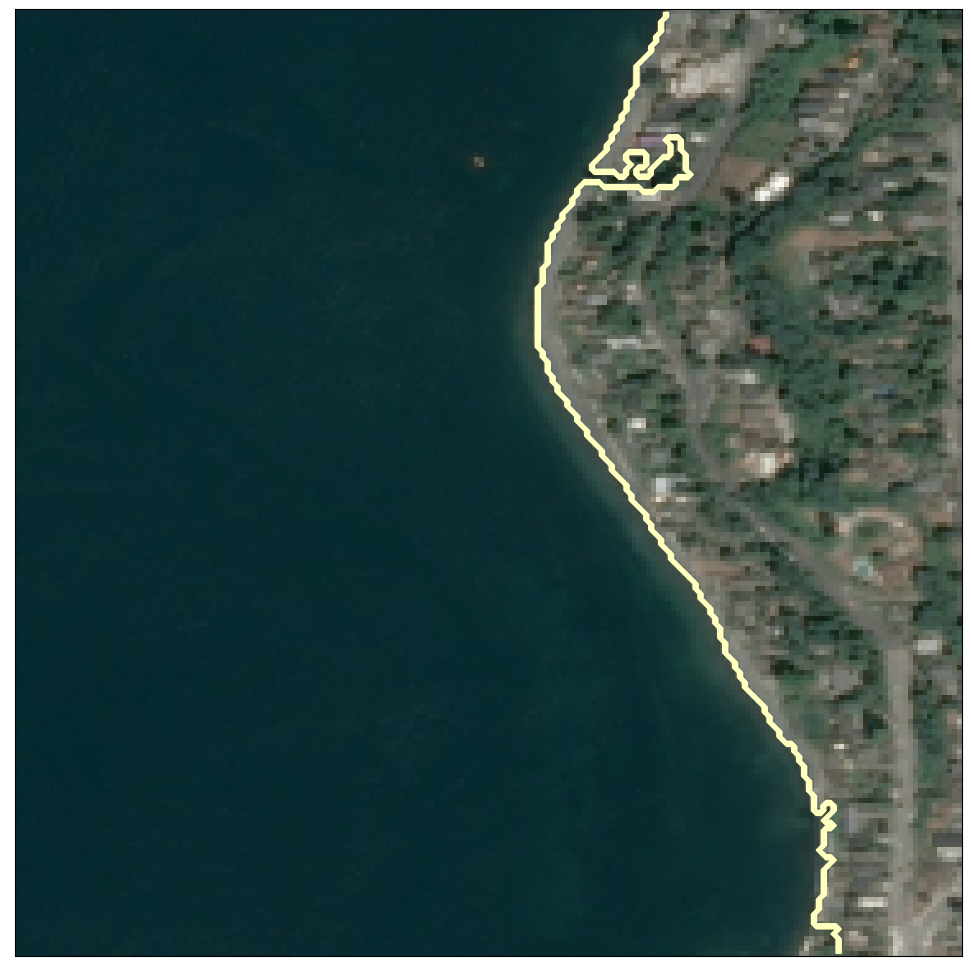

___________________________
image: 24


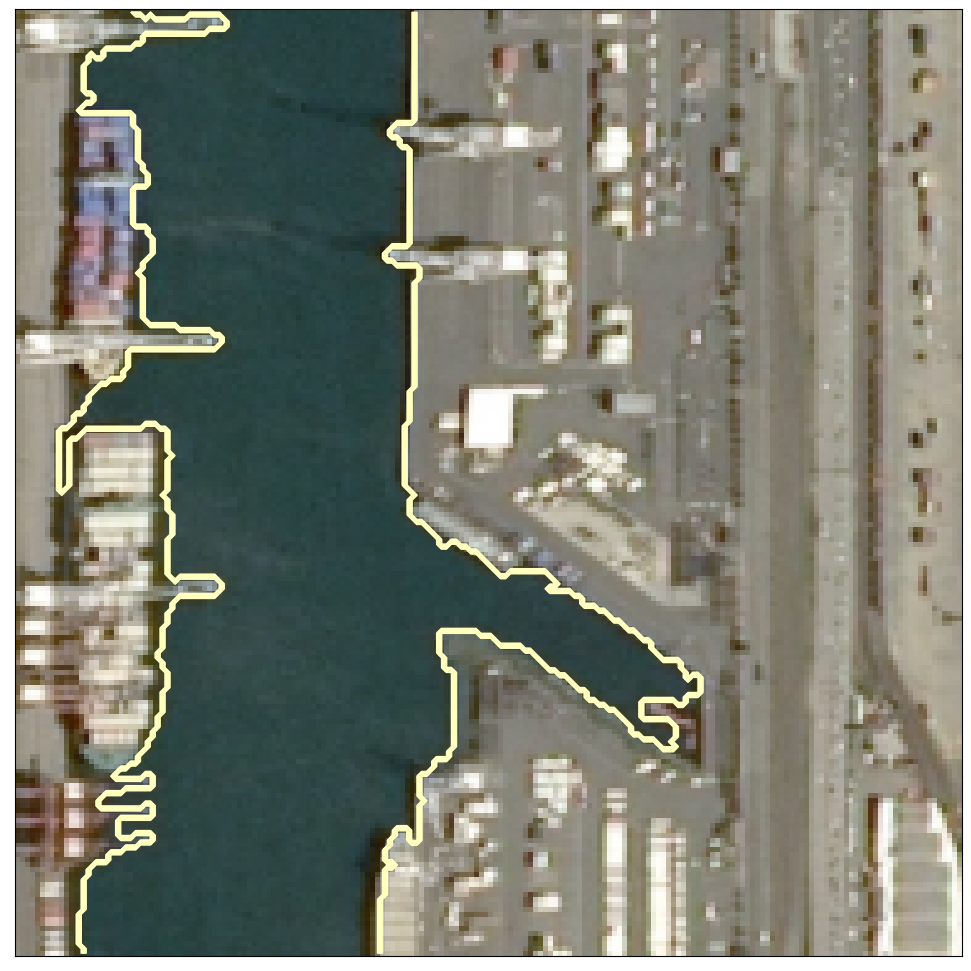

___________________________
image: 25


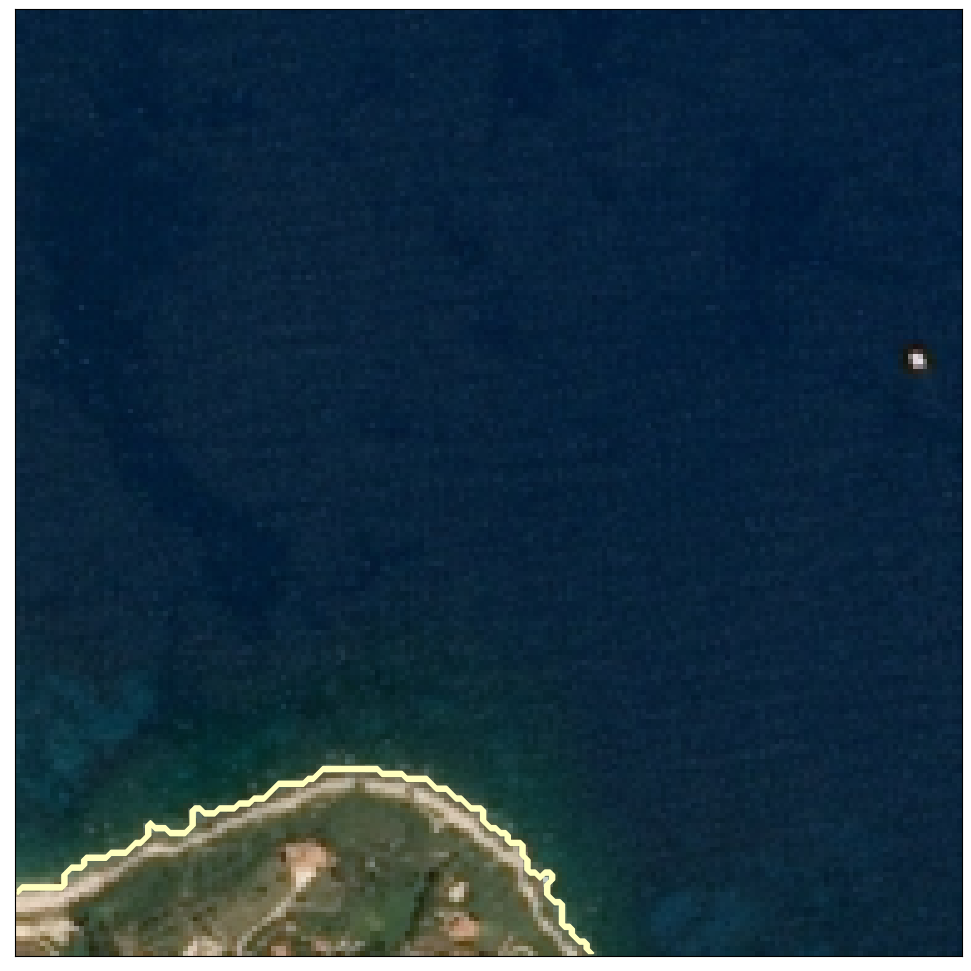

___________________________
image: 26


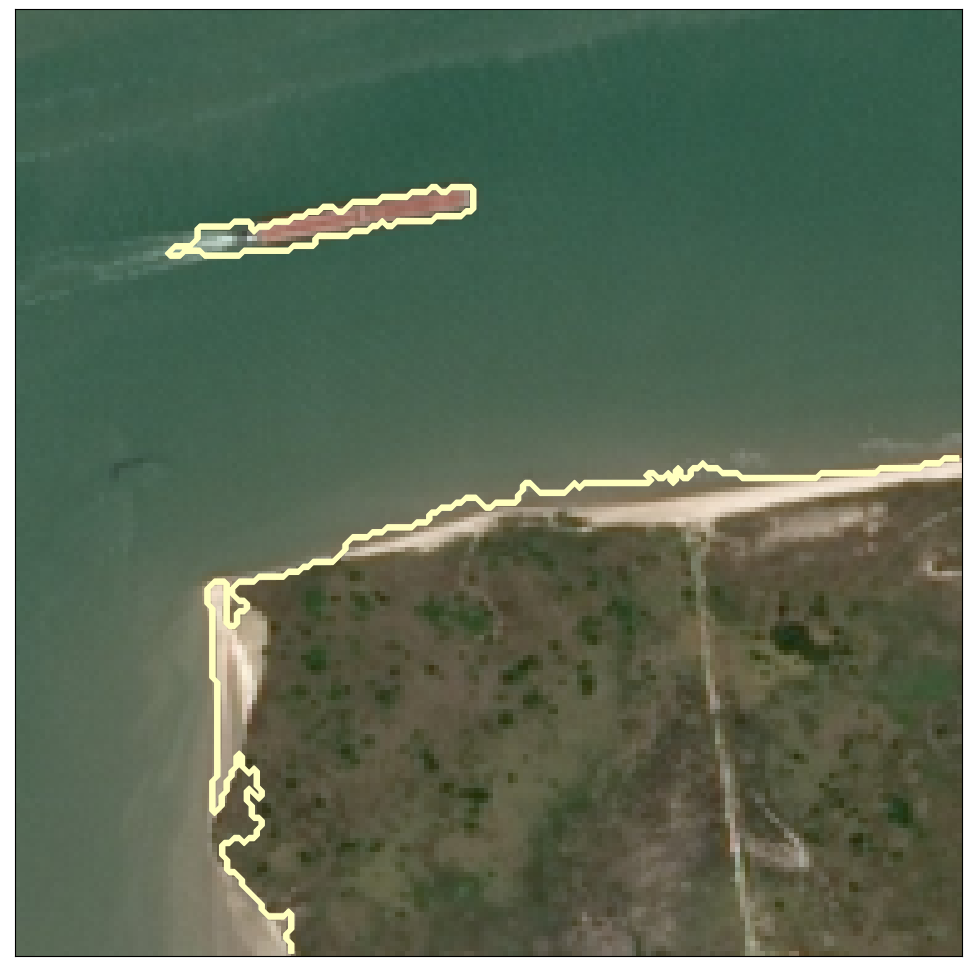

___________________________
image: 27


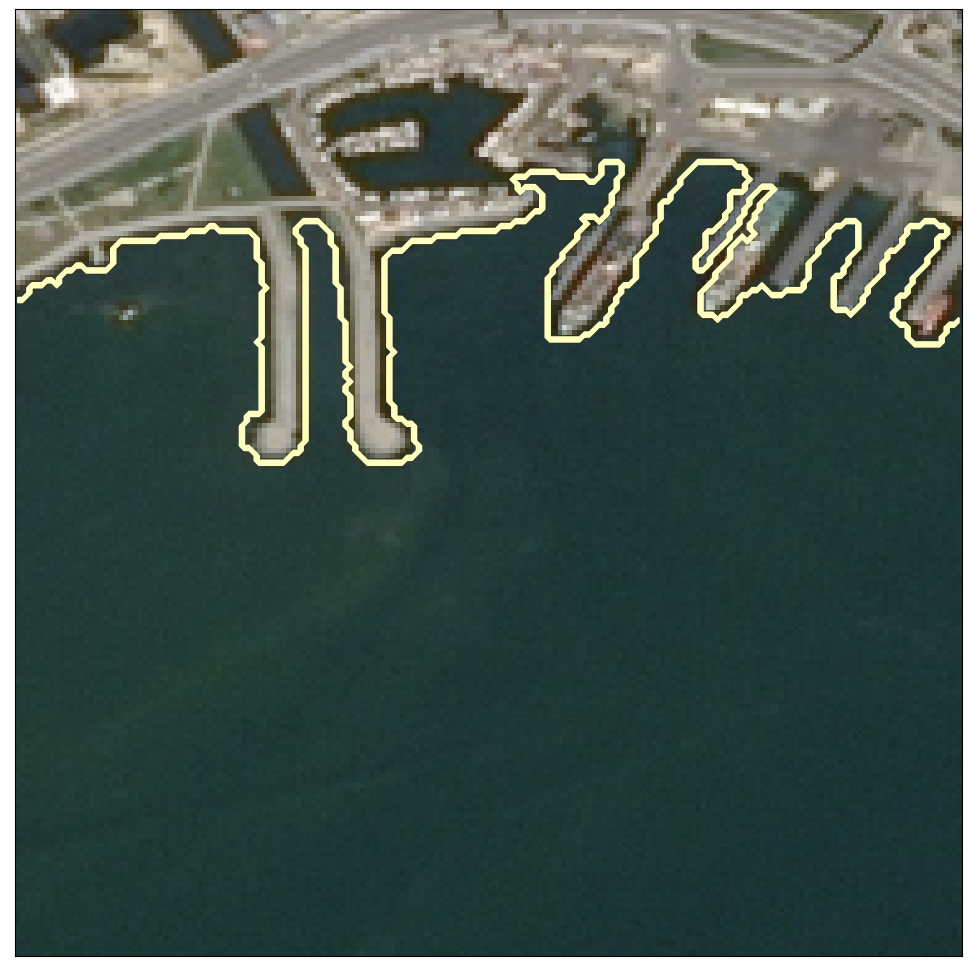

___________________________
image: 28


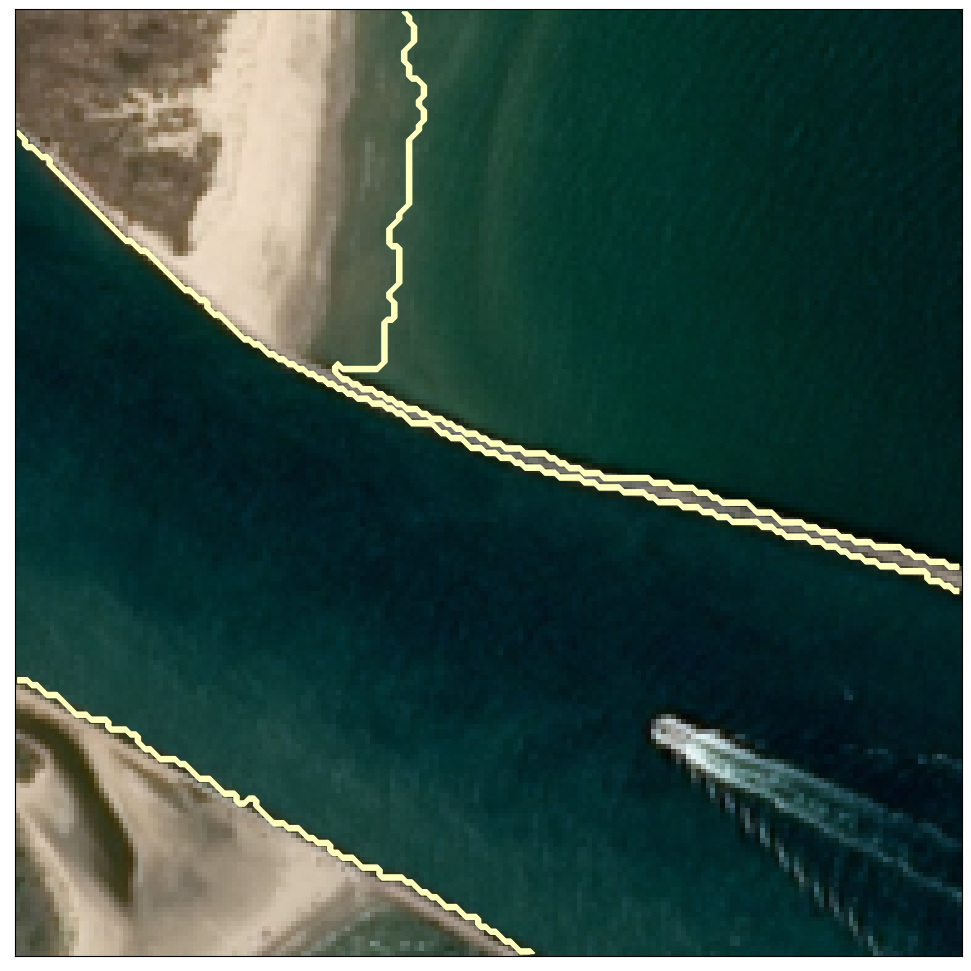

___________________________
image: 29


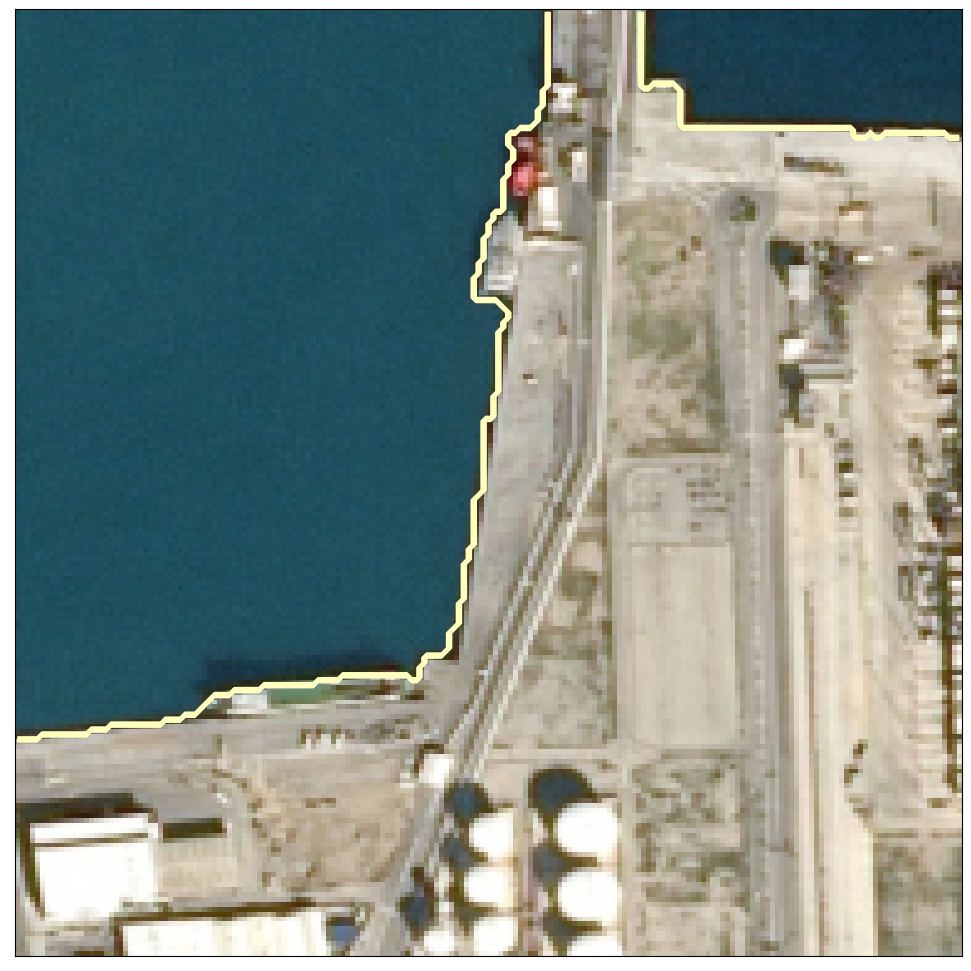

___________________________
image: 30


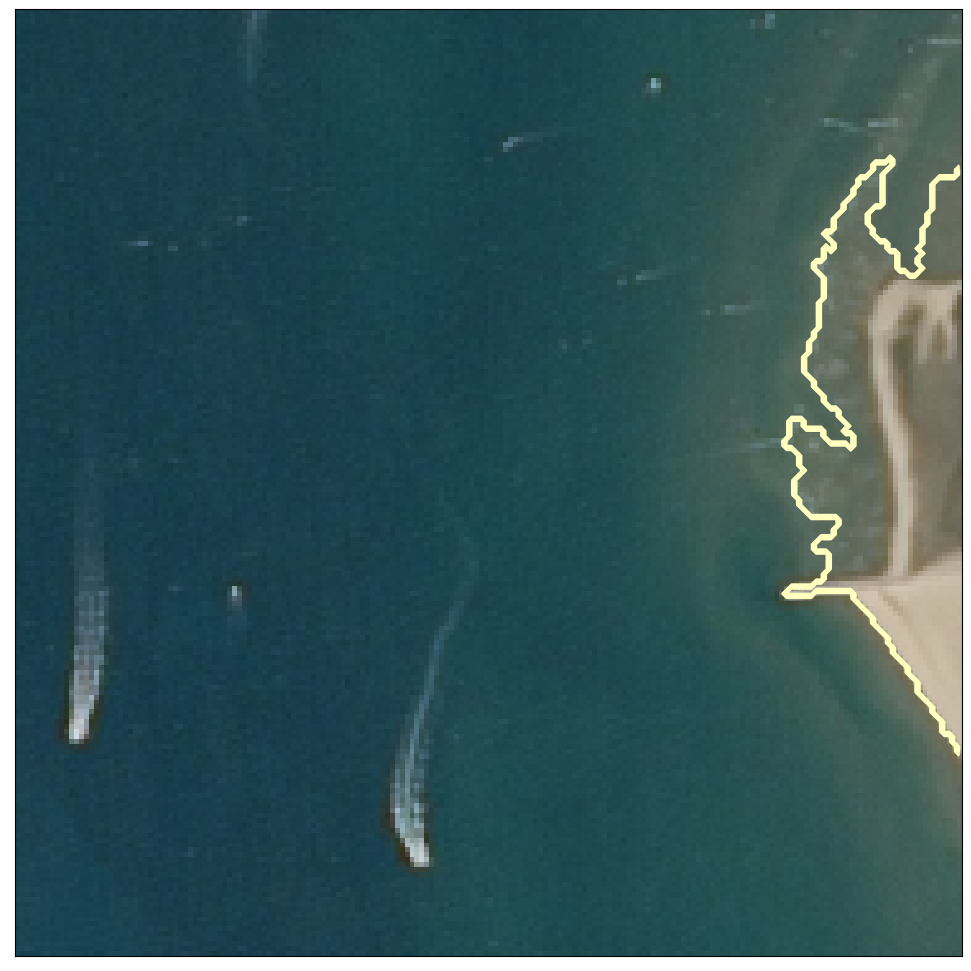

___________________________
image: 31


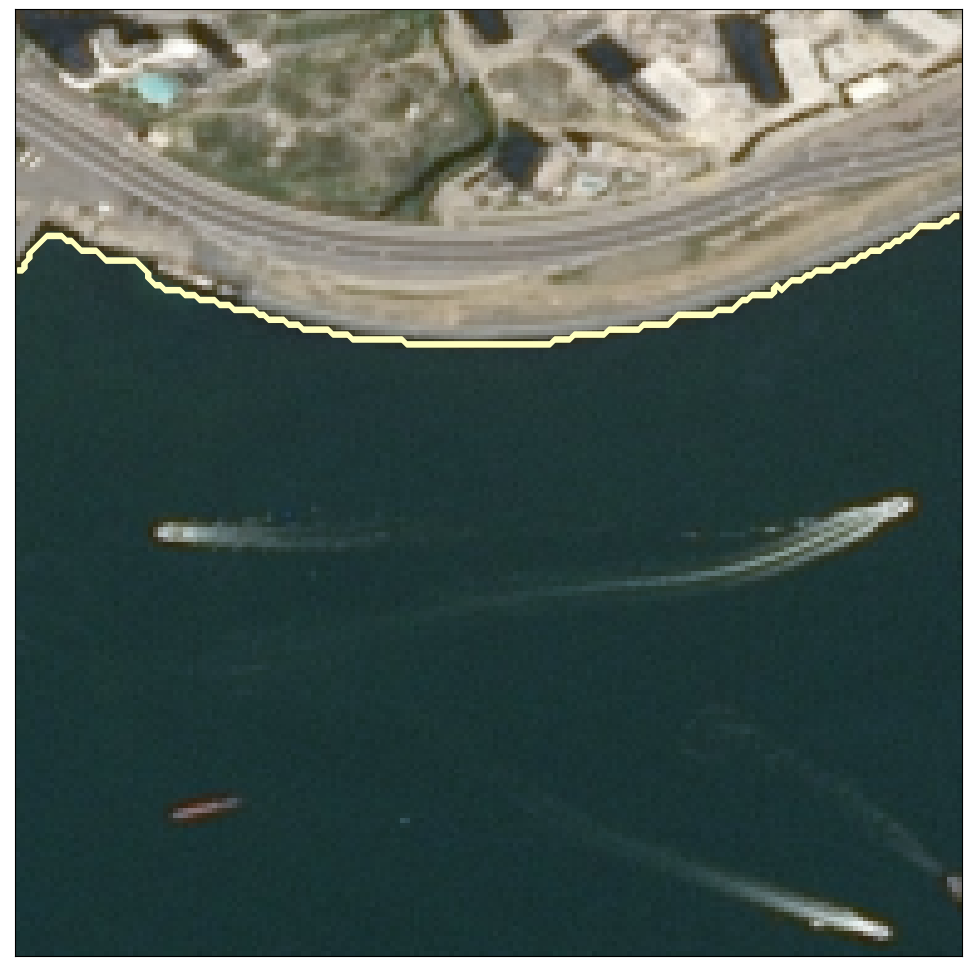

___________________________
image: 32


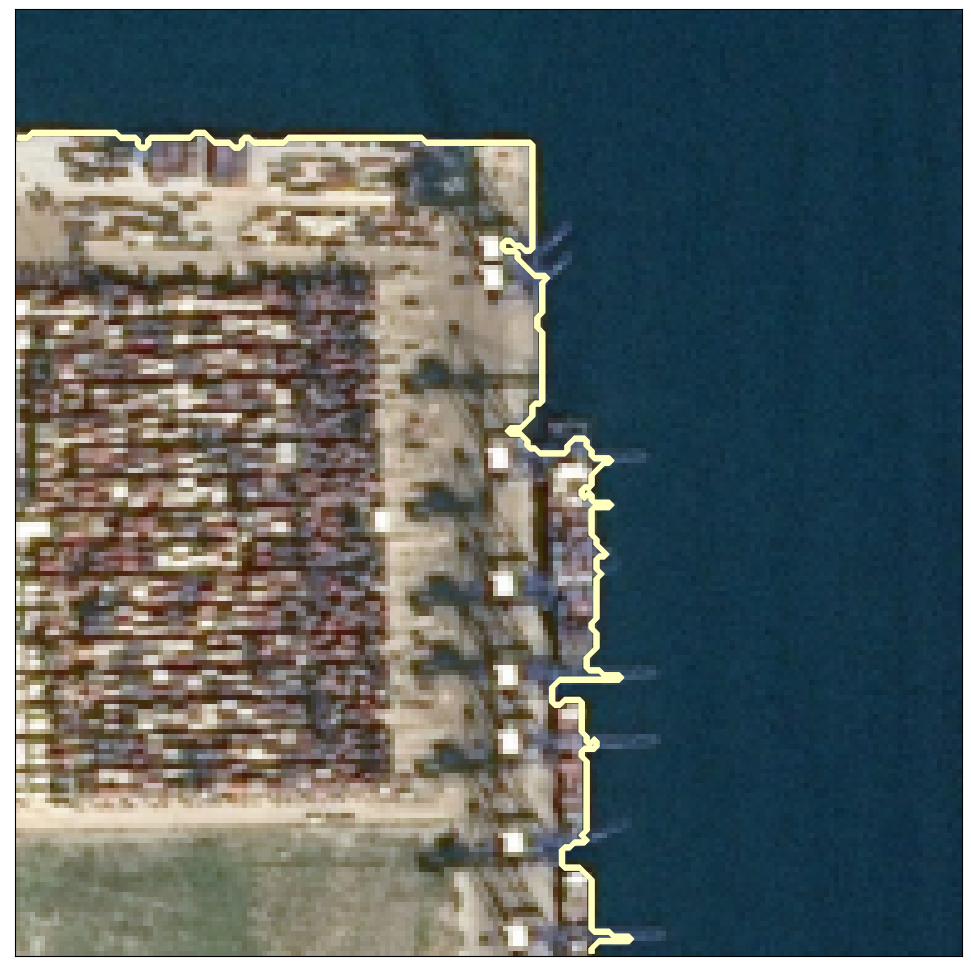

___________________________
image: 33


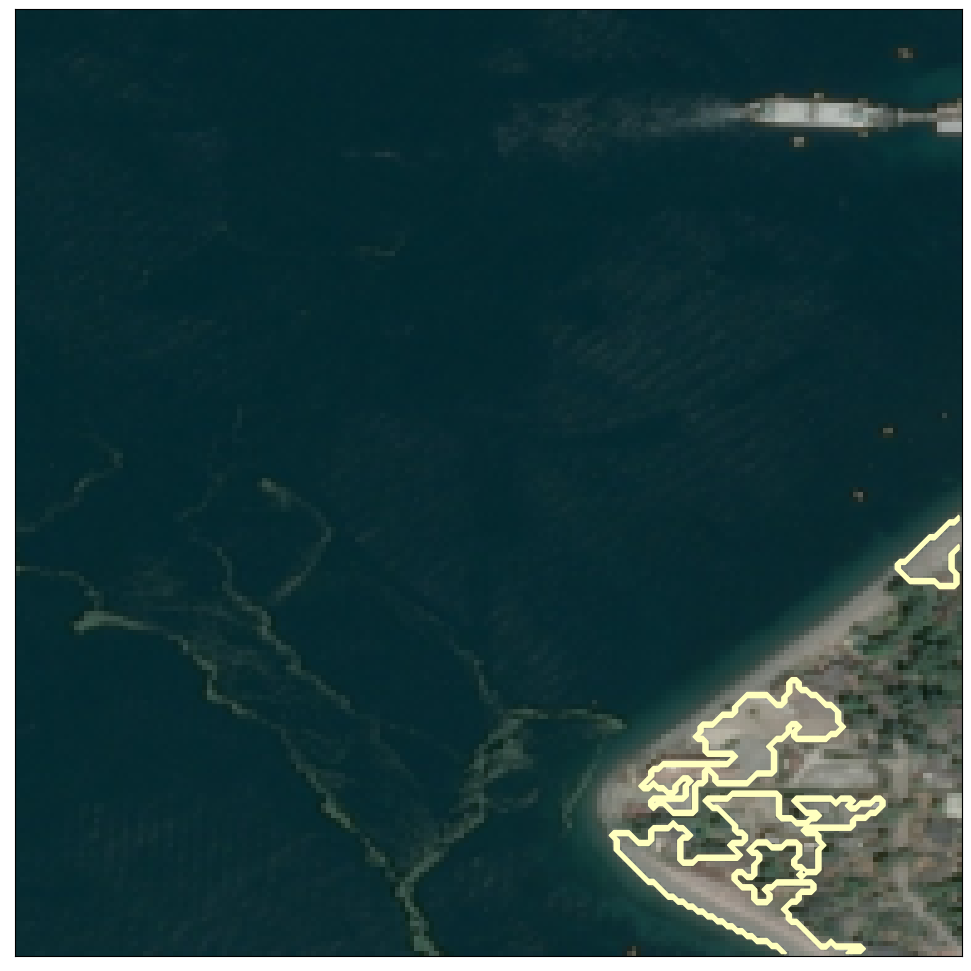

In [38]:
clusters(images, n_clusters=11, k_resize=4)